In [2]:
DBFILE = "allblocks.db" 
NAME_PREFIX="geth-clique-2s-gas40mio-RPC"

# analyze `....db` data

calculates & plots

* blocktime
* TPS (transactions per second), over 1, 3, 5, 10 consecutive blocks
* block size
* gasUsed and gasLimit per second

It needs an `allblocks-....db` database (created by `blocksDB_create.py`) containing all the blocks.

---

Please cite this as:

> Ethereum benchmarking scripts "chainhammer" and "chainreader"  
> by Dr Andreas Krueger, Electron.org.uk, London 2018  
> https://gitlab.com/electronDLT/chainhammer    

Consider to submit your improvements & usage as pull request --> [../other-projects.md](../other-projects.md).  Thanks.


---

<a id='chainhammer1000'>20000 transactions shot at a node</a>
# my own experiment: 
## 20000 transactions submitted with `chainhammer` 


    


## TOC

Code 

* [import from database](#Database)
* [simple statistics](#stats)
* [generate new columns](#columns)
* [4 diagrams in one](#code4diagrams)

Results

* [tables of peak TPS rates](#tables)
* [all 3 consecutive experiments](#allExperiments)
* [experiment 1](#experiment 1)
* [experiment 3](#experiment 3)


<a id='database'>Database</a>

In [3]:
#dependencies

import sqlite3; print("sqlite3 version", sqlite3.version)
import pandas; print("pandas version", pandas.__version__)
import numpy; print("numpy version", numpy.__version__)
import matplotlib; print("matplotlib version", matplotlib.__version__)

%matplotlib inline

# https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
matplotlib.rcParams['agg.path.chunksize'] = 10000

print ("\nReading blocks table from", DBFILE)

sqlite3 version 2.6.0
pandas version 1.0.5
numpy version 1.19.0
matplotlib version 3.2.2

Reading blocks table from allblocks.db


### TODO: refactoring
all the following functions could go into a separate `blocksDB_diagramming.py` for better recycling.

**For now, please simply scroll down.**

In [4]:
# open database connection
conn = sqlite3.connect(DBFILE)

# any SQL query 

def DB_query(SQL, conn):
    cur = conn.cursor()
    cur.execute(SQL)
    result = cur.fetchall()
    return result

print ("DB table names: ", DB_query("SELECT name FROM sqlite_master WHERE type='table';", conn)[0])

# number of rows?

def DB_tableSize(tablename, conn):
    """
    prints number of rows
    """
    count = DB_query("SELECT COUNT(*) FROM %s" % tablename, conn)
    print ("TABLE %s has %d rows" % (tablename, count[0][0]))
    return count
_=DB_tableSize("blocks", conn)

# what is the first & last block we have?

def maxBlockNumber(conn):
    result = DB_query("SELECT MIN(blocknumber), MAX(blocknumber) FROM blocks", conn)
    print ("MIN(blocknumber), MAX(blocknumber) = %s " % (result) )
    return result
minblock, maxblock = maxBlockNumber(conn)[0]

DB table names:  ('blocks',)
TABLE blocks has 40802 rows
MIN(blocknumber), MAX(blocknumber) = [(0, 40801)] 


In [5]:
blocknumbers = DB_query("SELECT blocknumber FROM blocks ORDER BY blocknumber", conn) 
print ("len(blocknumbers)=", len(blocknumbers))

len(blocknumbers)= 40802


In [6]:
# do we have consecutive blocks, none missing?

def check_whether_complete(blocknumbers):
    start = min(blocknumbers)[0]
    last = max(blocknumbers)[0]
    old = start-1
    total=0
    for bn in blocknumbers:
        bn = bn[0]
        missing=bn-old-1
        if missing>0:
            print ("from ", old+1, "to", bn - 1, "there are ", missing, " missing")
            total+=missing
        old = bn
    print()
    print ("complete" if not total else "some %d blocks missing" % total, end=" ")
    print ("between blocks %d and %d." %(min(blocknumbers)[0], max(blocknumbers)[0]))
    
check_whether_complete(blocknumbers)


complete between blocks 0 and 40801.


<a id='stats'>simple statistics</a>

In [7]:
# simple statistics

size_max = DB_query("SELECT MAX(size) FROM blocks", conn); print ("(block)size_max", size_max[0][0])
txcount_max = DB_query("SELECT MAX(txcount) FROM blocks", conn); print ("txcount_max", txcount_max[0][0])
txcount_av = DB_query("SELECT AVG(txcount) FROM blocks", conn); print ("txcount_av", txcount_av[0][0])
txcount_sum = DB_query("SELECT SUM(txcount) FROM blocks", conn); print ("txcount_sum", txcount_sum[0][0])
blocks_nonempty_count = DB_query("SELECT COUNT(blocknumber) FROM blocks WHERE txcount != 0", conn); print ("blocks_nonempty_count", blocks_nonempty_count[0][0])
print ("av tx per nonempty blocks = ", txcount_sum[0][0] / blocks_nonempty_count[0][0] )

(block)size_max 64812
txcount_max 400
txcount_av 0.04676241360717612
txcount_sum 1908
blocks_nonempty_count 18
av tx per nonempty blocks =  106.0


<a id='colums'>new columns</a>
## read whole table, and create new columns

In [8]:
# read whole table

# SQL="SELECT * FROM blocks WHERE 48500<blocknumber and blocknumber<49000 ORDER BY blocknumber"
SQL="SELECT * FROM blocks ORDER BY blocknumber"
df = pandas.read_sql(SQL, conn)

In [9]:
conn.close()

### `geth` based clients have a nanosecond timestamp

not anymore?

In [10]:
# transform nanoseconds to seconds
# df["timestamp"]=df["timestamp"]/1000000000
df[0:10]


,blocknumber,timestamp,size,gasUsed,gasLimit,txcount
0,0,1572336519,687,0,200000000,0
1,1,1594396734,607,0,200000000,0
2,2,1594396742,607,0,200000000,0
3,3,1594396744,607,0,200000000,0
4,4,1594396746,607,0,200000000,0
5,5,1594396748,607,0,200000000,0
6,6,1594396750,607,0,200000000,0
7,7,1594396752,607,0,200000000,0
8,8,1594396754,607,0,200000000,0
9,9,1594396756,607,0,200000000,0


In [11]:
# blocktime = timestamp[n] - timestamp[n-1]

def add_blocktime(df):
    df['blocktime'] = df['timestamp'] - df['timestamp'].shift()
    df.loc[1, "blocktime"] = numpy.nan
    
add_blocktime(df)


In [12]:
#df["TPS_1"]=df['txcount']/df['blocktime']
#df

In [13]:
# transactions per second
# with differently sized (rectangular) windows

def add_TPS(df, numBlocks):
    name = 'TPS_%dblks'%numBlocks if numBlocks>1 else 'TPS_%dblk'%numBlocks
    df[name]=df['txcount'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()
    
add_TPS(df, numBlocks=1)
add_TPS(df, numBlocks=3)
add_TPS(df, numBlocks=5)
add_TPS(df, numBlocks=10)

In [14]:
# gasUsed and gasLimit per second

def add_GUPS(df, numBlocks):
    name = 'GUPS_%dblks'%numBlocks if numBlocks>1 else 'GUPS_%dblk'%numBlocks
    df[name]=df['gasUsed'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

def add_GLPS(df, numBlocks):
    name = 'GLPS_%dblks'%numBlocks if numBlocks>1 else 'GLPS_%dblk'%numBlocks
    df[name]=df['gasLimit'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

add_GUPS(df, numBlocks=1)
add_GUPS(df, numBlocks=3)
add_GUPS(df, numBlocks=5)

add_GLPS(df, numBlocks=1)
add_GLPS(df, numBlocks=3)
add_GLPS(df, numBlocks=5)

<a id='tables'>tables of peak TPS rates</a>
## peak TPS rates

In [15]:
# peak TPS single block

df.sort_values(by=['TPS_1blk'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
2234,2234,1594401206,64812,25948400,200000000,400,2.0,200.0,66.666667,40.0,20.0,12974200.0,4.324733e+06,2594840.0,100000000.0,100000000.0,100000000.0
1438,1438,1594399614,64807,25948400,200000000,400,2.0,200.0,66.666667,40.0,20.0,12974200.0,4.324733e+06,2594840.0,100000000.0,100000000.0,100000000.0
118,118,1594396974,64424,26038400,200000000,400,2.0,200.0,66.666667,40.0,20.0,13019200.0,4.339733e+06,2603840.0,100000000.0,100000000.0,100000000.0
33418,33418,1594463574,20711,9991600,200000000,100,2.0,50.0,16.666667,10.0,10.0,4995800.0,1.665267e+06,999160.0,100000000.0,100000000.0,100000000.0
33438,33438,1594463614,20713,9991600,200000000,100,2.0,50.0,16.666667,10.0,5.0,4995800.0,1.665267e+06,999160.0,100000000.0,100000000.0,100000000.0
33411,33411,1594463560,17514,7388000,200000000,100,2.0,50.0,16.666667,10.0,10.0,3694000.0,1.231333e+06,738800.0,100000000.0,100000000.0,100000000.0
33176,33176,1594463090,14213,3814900,200000000,100,2.0,50.0,16.666667,10.0,5.0,1907450.0,6.358167e+05,381490.0,100000000.0,100000000.0,100000000.0
40293,40293,1594477324,14214,3814900,200000000,100,2.0,50.0,16.666667,10.0,5.0,1907450.0,6.358167e+05,381490.0,100000000.0,100000000.0,100000000.0
33406,33406,1594463550,14213,4753900,200000000,100,2.0,50.0,16.666667,10.0,5.0,2376950.0,7.923167e+05,475390.0,100000000.0,100000000.0,100000000.0
33213,33213,1594463164,14212,3814900,200000000,100,2.0,50.0,16.666667,10.0,5.0,1907450.0,6.358167e+05,381490.0,100000000.0,100000000.0,100000000.0


In [16]:
# peak TPS over ten blocks

df.sort_values(by=['TPS_10blks'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
2243,2243,1594401224,609,0,200000000,0,2.0,0.0,0.000000,0.0,20.0,0.0,0.000000e+00,0.0,100000000.0,100000000.0,100000000.0
120,120,1594396978,607,0,200000000,0,2.0,0.0,66.666667,40.0,20.0,0.0,4.339733e+06,2603840.0,100000000.0,100000000.0,100000000.0
2241,2241,1594401220,609,0,200000000,0,2.0,0.0,0.000000,0.0,20.0,0.0,0.000000e+00,0.0,100000000.0,100000000.0,100000000.0
2240,2240,1594401218,609,0,200000000,0,2.0,0.0,0.000000,0.0,20.0,0.0,0.000000e+00,0.0,100000000.0,100000000.0,100000000.0
2239,2239,1594401216,609,0,200000000,0,2.0,0.0,0.000000,0.0,20.0,0.0,0.000000e+00,0.0,100000000.0,100000000.0,100000000.0
2238,2238,1594401214,609,0,200000000,0,2.0,0.0,0.000000,40.0,20.0,0.0,0.000000e+00,2594840.0,100000000.0,100000000.0,100000000.0
1447,1447,1594399632,609,0,200000000,0,2.0,0.0,0.000000,0.0,20.0,0.0,0.000000e+00,0.0,100000000.0,100000000.0,100000000.0
127,127,1594396992,607,0,200000000,0,2.0,0.0,0.000000,0.0,20.0,0.0,0.000000e+00,0.0,100000000.0,100000000.0,100000000.0
126,126,1594396990,607,0,200000000,0,2.0,0.0,0.000000,0.0,20.0,0.0,0.000000e+00,0.0,100000000.0,100000000.0,100000000.0
125,125,1594396988,607,0,200000000,0,2.0,0.0,0.000000,0.0,20.0,0.0,0.000000e+00,0.0,100000000.0,100000000.0,100000000.0


<a id='code4diagrams'>code: 4 diagrams in one</a>
## all 4 diagrams in one

In [17]:
def diagrams(df, blockFrom, blockTo, prefix="", gas_logy=True, bt_logy=True):
    
    # https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
    matplotlib.rcParams['agg.path.chunksize'] = 10000
    
    # prepare 2x2 subplots
    plt = matplotlib.pyplot
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
    plt.tight_layout(pad=6.0, w_pad=6.0, h_pad=7.5)
    title = prefix + " blocks %d to %d" % (blockFrom, blockTo)
    plt.suptitle(title, fontsize=16)
    
    # bar charts are too expensive when too many blocks
    numBlocks =  blockTo - blockFrom
    kind = 'bar' if numBlocks<2000 else 'line'
    
    # TPS averages --> legend
    cols=['TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']
    averages=df[cols][blockFrom:blockTo].mean()
    legend = [col + " (av %.1f)" % averages[col] for col in cols]
    # print (legend)
    
    # TPS diagram
    cols = ['blocknumber'] + cols
    ax=df[cols][blockFrom:blockTo].plot(x='blocknumber', rot=90, ax=axes[0,0])
    ax.set_title("transactions per second")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.legend(legend);
    
    # BT
    ax=df[['blocknumber', 'blocktime']][blockFrom:blockTo].plot(x='blocknumber', kind=kind, ax=axes[0,1],
                                                               logy=bt_logy)
    ax.set_title("blocktime since last block")
    ax.locator_params(nbins=1, axis='x')  # TODO: Something is broken with matplotlib's ticks machinery
        
    # blocksize
    ax=df[['blocknumber', 'size']][blockFrom:blockTo].plot(x='blocknumber', rot=90, kind=kind, ax=axes[1,0])
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("blocksize in bytes")
    ax.locator_params(nbins=1, axis='x')  # TODO: Something is broken with matplotlib's ticks machinery
    
    # gas
    ax=df[['blocknumber', 'GLPS_1blk', 'GUPS_1blk']][blockFrom:blockTo].plot(x='blocknumber', 
                                                                             rot=90, ax=axes[1,1], 
                                                                             logy=gas_logy)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    if not gas_logy:
        ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("gasUsed and gasLimit per second")
    
    # save diagram to PNG file
    fig.savefig("img/%s_tps-bt-bs-gas_blks%d-%d.png" % (prefix,blockFrom,blockTo))


# <a id='allExperiments'>whole chain</a>


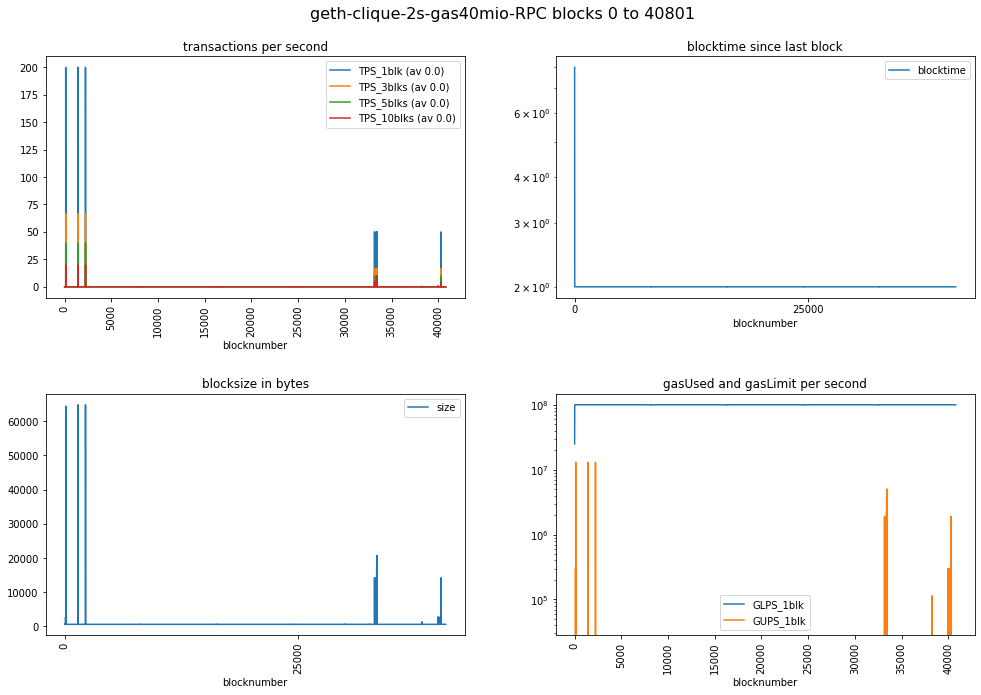

In [18]:
# the whole range of blocks

diagrams(df, 0, len(blocknumbers)-1, NAME_PREFIX, gas_logy=True, bt_logy=True)

<a id='experiment1'>zoom in on one experiment</a>

# final experiment ...


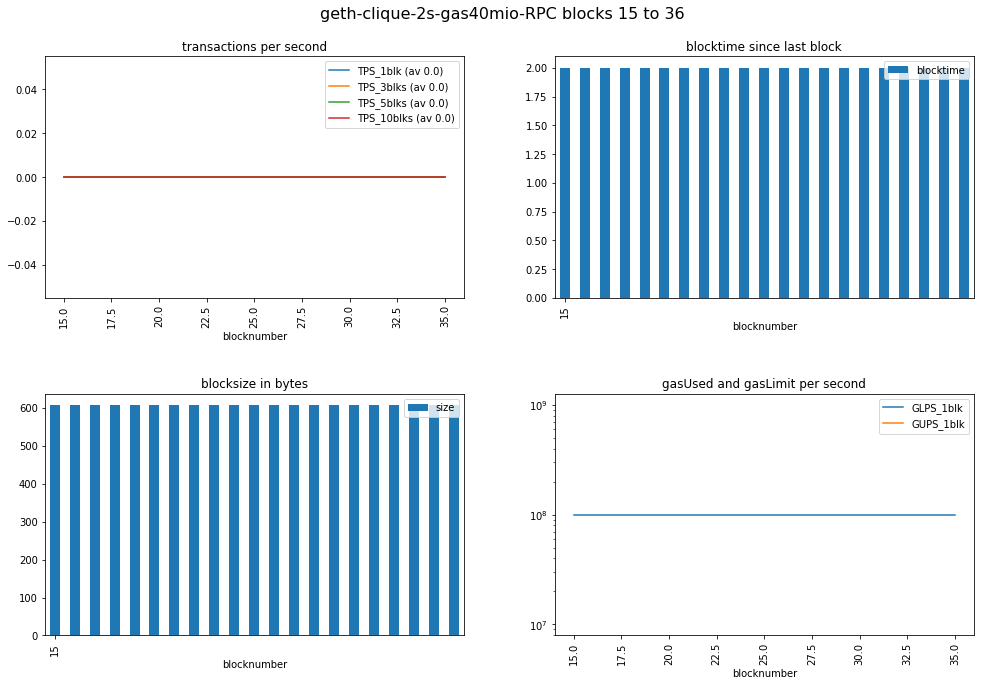

In [19]:
# starting only at block xx because the waiting time before experiment start

diagrams(df, 15, 36, NAME_PREFIX, gas_logy=True, bt_logy=False)

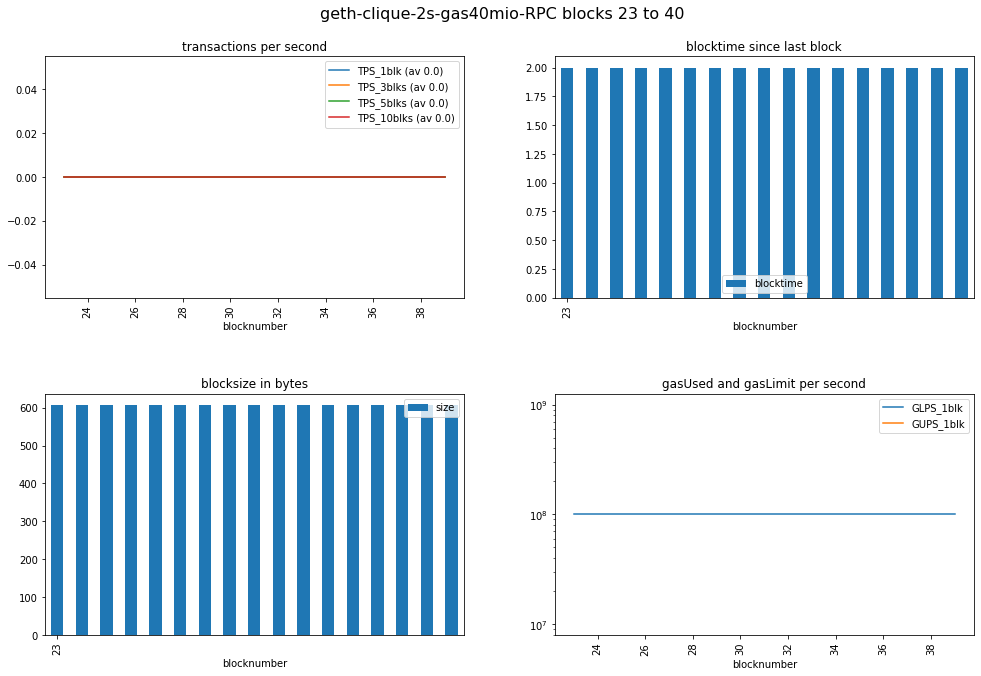

In [20]:
diagrams(df, 23, 40, NAME_PREFIX, gas_logy=True, bt_logy=False)

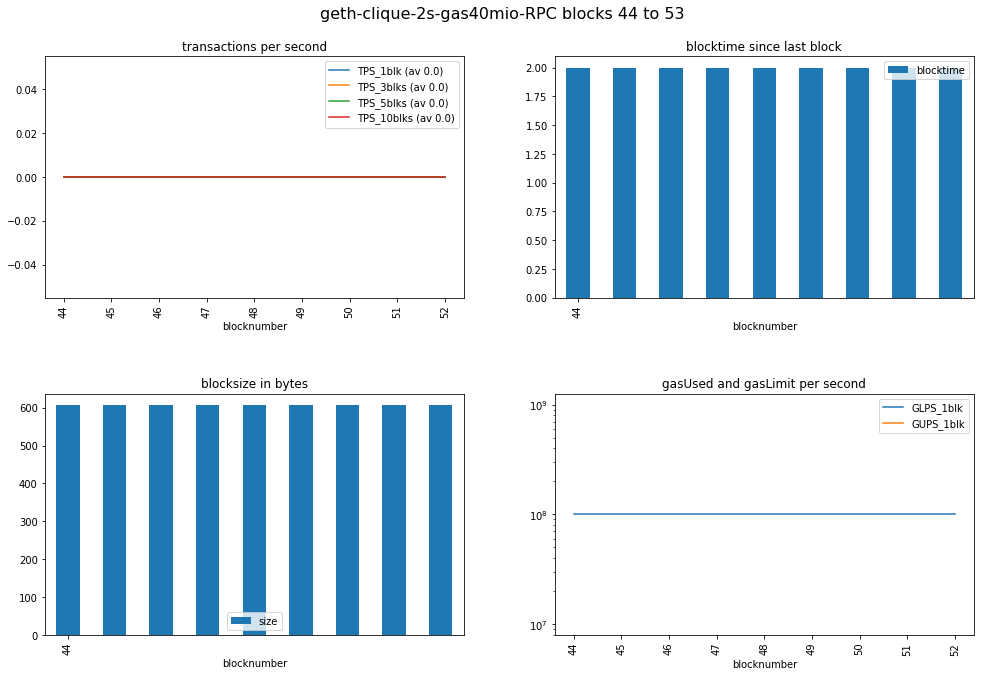

In [21]:
diagrams(df, 44, 53, NAME_PREFIX, gas_logy=True, bt_logy=False)

In [22]:
# what's wrong with the y-axis tick labels?

print (df["gasLimit"][44:52].mean())
print (df["gasUsed"][44:52].mean())

200000000.0
0.0


In [23]:
df["size"][44:52].mean()

607.0